In [1]:
from pymongo import MongoClient
from concurrent.futures import ThreadPoolExecutor
from threading import Lock
import time
import math
import matplotlib.pyplot as plt
import os

Створення конектора до серверу з базою даних **mongodb**.

In [2]:
lock = Lock()

MONGODB_URI = os.environ.get("MONGODB_URI", "mongodb://localhost:27017")
client = MongoClient(MONGODB_URI, username="root", password="root")
db = client.cafes
cafes = db.cafes

Функції для роботи з базою даних. Дві основні операції: вибір(select) та оновлення(update).

In [3]:
def change_rating(from_cafe, to_cafe, amount):
    cafe = cafes.find_one({'name': from_cafe})
    
    lock.acquire()
    cafes.update_one({'name': from_cafe}, {'$inc': {'rating': -amount}})
    cafes.update_one({'name': to_cafe}, {'$inc': {'rating': amount}})
    lock.release()

def increase_rating(to_cafe, amount):
    lock.acquire()
    cafes.update_one({'name': to_cafe}, {'$inc': {'rating': amount}})
    lock.release()

Функція для запуску futures.

In [4]:
def run_transactions(num_threads=50, num_transactions=100):
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = []
        start_time = time.time()
        
        for _ in range(num_transactions):
            futures.append(executor.submit(lambda: change_rating("Starbucks", "Cafe Coffee Day", 0.01)))
            futures.append(executor.submit(lambda: change_rating("Cafe Coffee Day", "Dunkin Donuts", 0.01)))
            futures.append(executor.submit(lambda: change_rating("Dunkin Donuts", "Tim Hortons", 0.01)))

        for _ in range(math.floor(num_transactions / 2)):
            futures.append(executor.submit(lambda: increase_rating("Starbucks", 0.01)))
            futures.append(executor.submit(lambda: increase_rating("Cafe Coffee Day", 0.01)))

        for future in futures:
            future.result()

        executor.shutdown()
        
        end_time = time.time()
        return end_time - start_time

Основний цикл роботи усієї програми.

In [5]:
num_threads = 50
num_transactions = 100
iterations = 50
times = []
for i in range(iterations):
    time_taken = run_transactions(num_threads = 50, num_transactions = 100)
    times.append(time_taken)
    print(f'Completed {num_transactions + num_transactions / 2} transactions in {i+1} iteration in {time_taken:.4f} seconds')

Completed 150.0 transactions in 1 iteration in 0.6361 seconds
Completed 150.0 transactions in 2 iteration in 0.5529 seconds
Completed 150.0 transactions in 3 iteration in 0.5587 seconds
Completed 150.0 transactions in 4 iteration in 0.5589 seconds
Completed 150.0 transactions in 5 iteration in 0.5677 seconds
Completed 150.0 transactions in 6 iteration in 0.5515 seconds
Completed 150.0 transactions in 7 iteration in 0.5505 seconds
Completed 150.0 transactions in 8 iteration in 0.5917 seconds
Completed 150.0 transactions in 9 iteration in 0.6276 seconds
Completed 150.0 transactions in 10 iteration in 0.5617 seconds
Completed 150.0 transactions in 11 iteration in 0.6187 seconds
Completed 150.0 transactions in 12 iteration in 0.5729 seconds
Completed 150.0 transactions in 13 iteration in 0.5550 seconds
Completed 150.0 transactions in 14 iteration in 0.6115 seconds
Completed 150.0 transactions in 15 iteration in 0.5937 seconds
Completed 150.0 transactions in 16 iteration in 0.5651 seconds
C

Побудова графіка роботи програми.

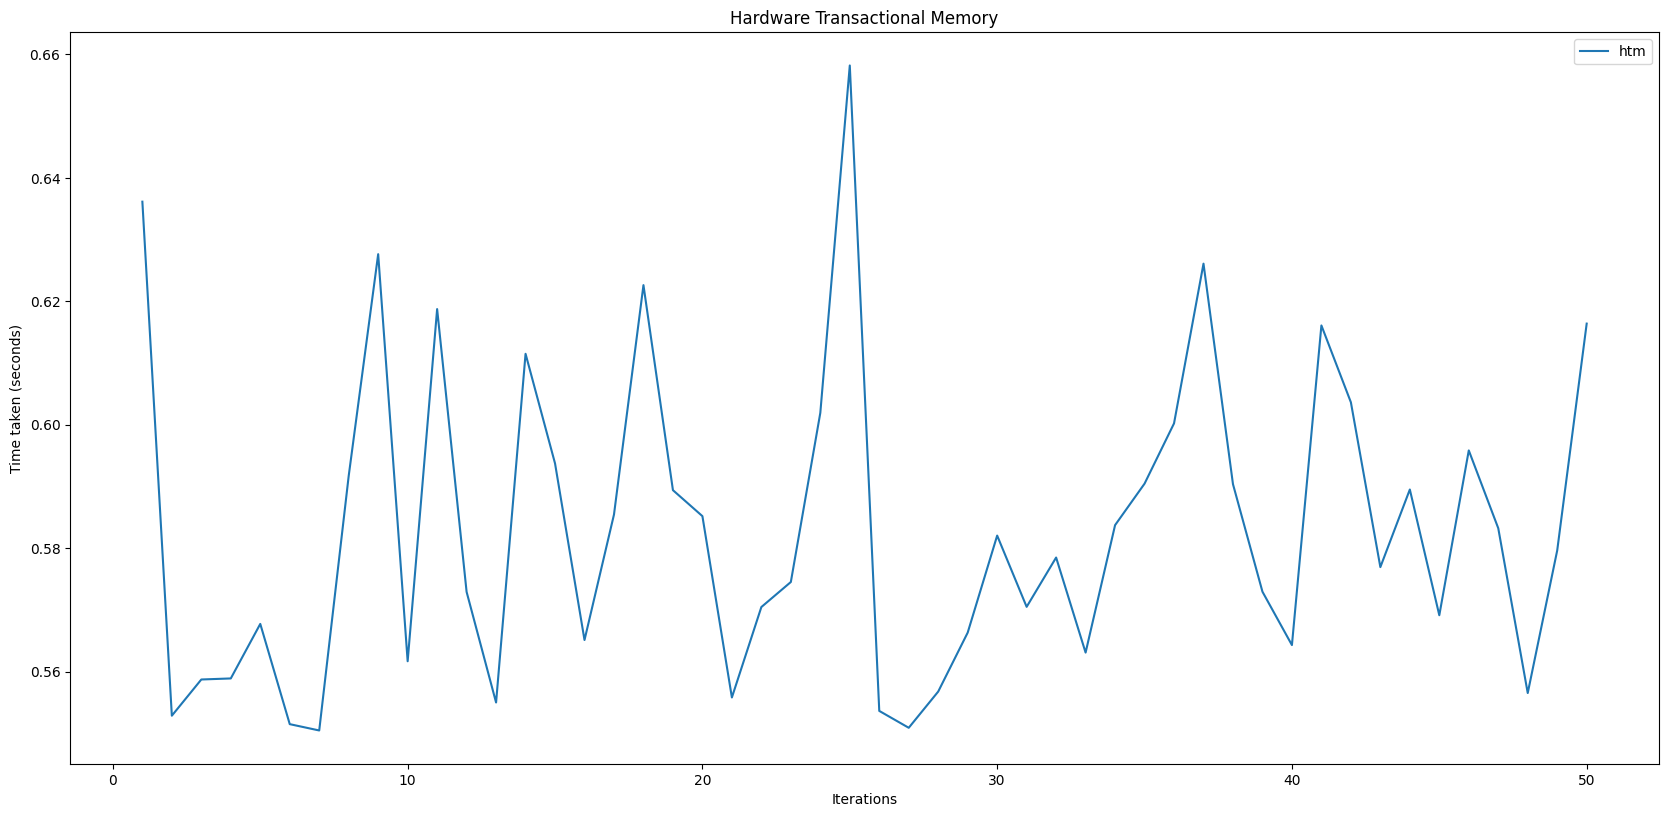

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(20.5, 9.5)
ax.plot(range(1, iterations+1), times, label='htm')
ax.set_xlabel('Iterations')
ax.set_ylabel('Time taken (seconds)')

ax.set_title('Hardware Transactional Memory')
ax.legend()
plt.show()